In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
df1=pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
df1.head()
df1.shape

(5531451, 191)

In [3]:
df_label = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
df_label.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [4]:
#load train data w/o running out of mem
#chunk_size=200000
#batch_no=0

#for chunk in pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv',chunksize=chunk_size):
    #chunk.to_csv('train'+str(batch_no)+'.csv',index=False)
    #chunk.to_parquet('train'+str(batch_no)+'.parquet',index=False)
    #print(batch_no)
    #df = pd.read_csv('train'+str(batch_no)+'.csv')
    #df.to_parquet('train'+str(batch_no)+'.parquet')
    #batch_no+=1
    

In [5]:
#checking out data types
print(df1.dtypes.value_counts())
list(df1.select_dtypes(['object']).columns)

float32    185
object       4
int64        2
dtype: int64


['customer_ID', 'S_2', 'D_63', 'D_64']

In [6]:
#visualizing columns

#hist = df1.hist(bins=10, figsize = (40,200), layout=(-1,4) )

In [7]:
#inspecting NaN

for i in range(len(df1.columns)):
    if (df1.iloc[:,i].isnull().sum()/len(df1) > 0.5):
        print(df1.columns[i], round(df1.iloc[:,i].isnull().sum()/len(df1),2))

#drop columns with high freq of NaN
columns_to_drop = [column for column in df1.columns if df1[column].isnull().sum()/df1.shape[0] >= 0.3]
df1.drop(columns_to_drop, axis=1)


D_42 0.86
D_49 0.9
D_50 0.57
D_53 0.74
D_56 0.54
S_9 0.53
B_17 0.57
D_66 0.89
D_73 0.99
D_76 0.89
R_9 0.94
D_82 0.73
B_29 0.93
D_87 1.0
D_88 1.0
D_105 0.55
D_106 0.9
R_26 0.89
D_108 0.99
D_110 0.99
D_111 0.99
B_39 0.99
B_42 0.99
D_132 0.9
D_134 0.96
D_135 0.96
D_136 0.96
D_137 0.96
D_138 0.96
D_142 0.83


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,0.005972,0.004345,0.001535,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,0.004838,0.007495,0.004931,0.003954,0.003167,0.005032,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,0.005497,0.009227,0.009123,0.003269,0.007329,0.000427,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,0.008261,0.007206,0.002409,0.006117,0.004516,0.003200,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,0.004848,0.006312,0.004462,0.003671,0.004946,0.008889,0.001670,0.008126,0.009827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,0.416013,0.020818,0.828199,0.003487,0.090743,0.005340,0.025139,...,0.004508,0.000776,0.007069,0.006838,0.003680,0.000457,0.000905,0.001498,0.002774,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,0.296536,0.007209,0.812610,0.005904,0.079886,0.002243,0.023691,...,0.003406,0.001741,0.002056,0.003310,0.007097,0.007857,0.002777,0.008225,0.008856,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,0.443984,0.013151,0.815422,0.003457,0.100503,0.002111,0.012343,...,0.002946,0.006060,0.005076,0.009955,0.009994,0.001088,0.005693,0.006773,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,0.442553,0.009855,1.003541,0.005117,0.101802,0.009930,0.008578,...,0.008511,0.003811,0.008682,0.005541,0.006564,0.009883,0.008123,0.001168,0.003983,0


In [8]:
#using only most recent transaction from each customer

df1=df1.set_index(['customer_ID'])
print('1')
df1=df1.ffill()
print('2')
df1=df1.bfill()
df1=df1.reset_index()

df1=df1.groupby('customer_ID').tail(1)
df1=df1.set_index(['customer_ID'])

#Drop date column since it is no longer relevant
df1.drop(['S_2'],axis=1,inplace=True)
#Check for number of rows
df1.shape

1
2


(458913, 189)

In [9]:
print(df1.shape)
# Create correlation matrix
corr_matrix = df1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
df1.drop(to_drop, axis=1, inplace=True)

print(df1.shape)

(458913, 189)
(458913, 175)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [10]:
#removing outliers
##print(df1.shape)

#df1 = df1[df1['R_6'] < df1['R_6'].quantile(0.97)]
#print(df1['R_6'].max())
#print(df1.shape)

In [11]:
#df1.iloc[:100000,7].value_counts()
#print(df1.iloc[:,1].head())


#What type of variable for dates
#df1['S_2'] = pd.to_datetime(df1['S_2'])
#df1['S_2'] = pd.to_numeric(df1['S_2'])

#normalizing
#df1['S_2'] = (df1['S_2']-df1['S_2'].min())/(df1['S_2'].max() - df1['S_2'].min())
#print(df1['S_2'].head())

#df1['S_2'] = pd.to_timedelta(df1['S_2'])
#print(df1.iloc[:,1].dt.total_seconds())

In [12]:
df1 = pd.get_dummies(df1)

In [13]:
#plt.figure(1, figsize =  (90,90))
#corr = df1.corr()
#sns.heatmap(corr, cmap = "rocket", annot = True)

In [14]:
#Handling missing values
my_imputer = SimpleImputer()
impd = my_imputer.fit_transform(df1.iloc[:,:])
df1.iloc[:,:] = impd
df1 = df1.drop('target', axis=1)


In [15]:
X = df1.iloc[:, :].values.reshape(-1, len(df1.columns))
Y = df_label.iloc[:len(df1), 1].values.reshape(-1, 1)
print('half')
# create object for the class
log = LogisticRegression(max_iter=1000)
log.fit(X, Y) 
Y_pred = log.predict(X)

print(Y_pred, np.sum(Y_pred))
print(log.score(X, Y))




half


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 0 0 ... 0 0 0] 113368
0.8959149119767799


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
print(df_label.head())
print(df_label.iloc[:10000, 1].sum( ))

                                         customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0
2649


Accuracy: 0.8959149119767799
0.8569192390671468


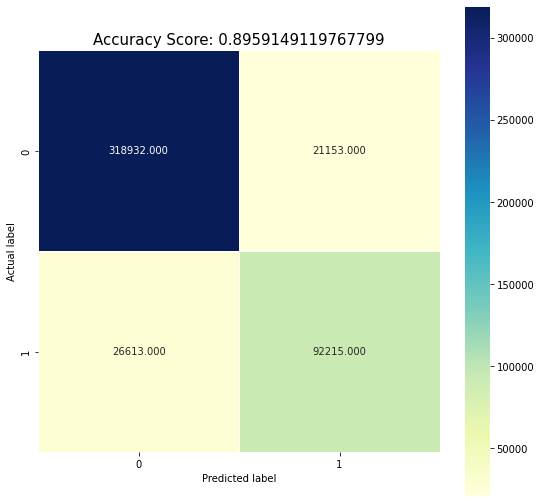

In [17]:
cm = metrics.confusion_matrix(Y, Y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(log.score(X, Y))
plt.title(all_sample_title, size = 15);

print('Accuracy:',metrics.accuracy_score(Y, Y_pred))
metrics.roc_curve(Y, Y_pred)
print(metrics.roc_auc_score(Y, Y_pred))